In this notebook: see if we can fit all boxes at once in a hierarchical way

In [1]:
import os
os.environ['THEANO_FLAGS'] = "device=cpu"

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import theano as th
import theano.tensor as T
import pymc3 as pm
import cPickle as pickle
import csv
from statistics import median
from mpl_toolkits.mplot3d import axes3d

th.config.compute_test_value = 'ignore'

In [2]:
# Get the data
boxes = ['MultiJet', 'DiJet', 'LeptonMultiJet', 'LeptonJet']
sideband_x = {'MultiJet':650, 'DiJet':650, 'LeptonMultiJet':550, 'LeptonJet':550}
sideband_y = {'MultiJet':0.3, 'DiJet':0.3, 'LeptonMultiJet':0.2, 'LeptonJet':0.2}
btag_max = {'MultiJet':3, 'DiJet':2, 'LeptonMultiJet':3, 'LeptonJet':2}
data = { box:pd.read_csv("data/RazorFitInstance_Razor2016_MoriondRereco_{}.csv".format(box), index_col='NBtags')
           for box in boxes }
sideband_data = { box:data[box][ (data[box]['MR'] < sideband_x[box]) | (data[box]['Rsq'] < sideband_y[box]) ]
                    for box in boxes}

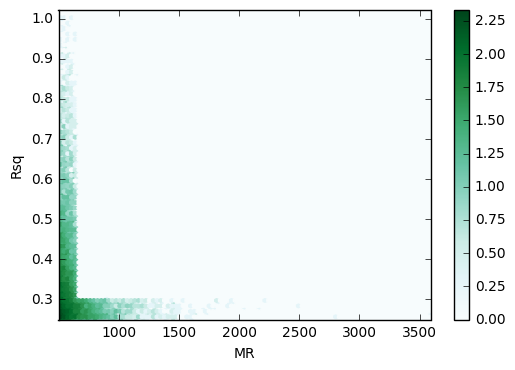

In [3]:
# Check the data
ax = sideband_data['MultiJet'].plot(kind='hexbin', x='MR', y='Rsq', bins='log', sharex=False);
plt.show()

In [4]:
class Sideband(object):
    """Class storing razor sideband geometry info."""
    def __init__(self, MRMin=500, MRMax=4000, RsqMin=0.25, RsqMax=1.5, 
                MRSidebandMax=650, RsqSidebandMax=0.30):
        self.MRMin = T.as_tensor_variable(MRMin)
        self.MRMax = T.as_tensor_variable(MRMax)
        self.RsqMin = T.as_tensor_variable(RsqMin)
        self.RsqMax = T.as_tensor_variable(RsqMax)
        self.MRSidebandMax = T.as_tensor_variable(MRSidebandMax)
        self.RsqSidebandMax = T.as_tensor_variable(RsqSidebandMax)
        
        # as floats
        self.MRMin_ = MRMin
        self.MRMax_ = MRMax
        self.RsqMin_ = RsqMin
        self.RsqMax_ = RsqMax
        self.MRSidebandMax_ = MRSidebandMax
        self.RsqSidebandMax_ = RsqSidebandMax
        
    def in_sideband(self, MR, Rsq):
        not_in = ( (MR < self.MRMin) + (MR > self.MRMax) + (Rsq < self.RsqMin) + (Rsq > self.RsqMax) 
                  + ((MR > self.MRSidebandMax)*(Rsq > self.RsqSidebandMax)) )
        return not_in < 1
        
hadronic_sideband = Sideband(500, 4000, 0.25, 1.5, 650, 0.30)
leptonic_sideband = Sideband(400, 4000, 0.15, 1.5, 550, 0.20)

hadronic_mr_sideband = Sideband(500, 650, 0.25, 1.5, 650, 1.5)
hadronic_rsq_sideband = Sideband(500, 4000, 0.25, 0.30, 4000, 0.30)

leptonic_mr_sideband = Sideband(400, 550, 0.15, 1.5, 550, 1.5)
leptonic_rsq_sideband = Sideband(400, 4000, 0.15, 0.20, 4000, 0.20)

In [5]:
def razor_p(MR, Rsq, P, n, A, B, MRMin, RsqMin):
    """Computes razor probability density (numpy version)."""
    term1 = P * np.power((MR-MRMin+A)/A * (Rsq-RsqMin+B)/B, 1./n)
    prob = np.exp(-term1) 
    return prob

def razor_int(P, n, A, B, MRMin, MRMax, RsqMin, RsqMax, sideband):
    """Computes razor integral in a rectangular region"""
    func = lambda y, x: razor_p(x, y, P, n, A, B, sideband.MRMin_, sideband.RsqMin_)
    RsqLow = lambda x: RsqMin
    RsqHigh = lambda x: RsqMax
    return sp.integrate.dblquad(func, MRMin, MRMax, RsqLow, RsqHigh)[0]

def razor_norm(P, n, A, B, sideband):
    norm_MR_sideband = razor_int(P, n, A, B, sideband.MRMin_, sideband.MRSidebandMax_, 
                                          sideband.RsqMin_, sideband.RsqMax_, sideband)
    norm_Rsq_sideband = razor_int(P, n, A, B, sideband.MRSidebandMax_, sideband.MRMax_, 
                                          sideband.RsqMin_, sideband.RsqSidebandMax_, sideband)
    return norm_MR_sideband + norm_Rsq_sideband

def razor_p_sidebandnormalized(MR, Rsq, P, n, A, B, nevents, sideband=hadronic_sideband):
    """Returns probability normalized to the given number of events in the given sideband"""
    p = razor_p(MR, Rsq, P, n, A, B, sideband.MRMin_, sideband.RsqMin_)
    norm = razor_norm(P, n, A, B, sideband)
    return nevents*p/norm

In [6]:
# Using scipy's integration functionality we can directly compute the razor pdf integral numerically.
# This may allow us to move to pdfs whose norm is not analytically calculable.  

class RazorIntegral(th.Op):
    """Inputs: P, n1, n2, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin
       Output: pdf integral"""
    __props__ = ()
    epsilon = 1e-7
    
    def make_node(self, *inputs):
        inputs = [T.as_tensor_variable(inp) for inp in inputs]
        output = T.dscalar()
        return th.Apply(self, inputs, [output])
    
    def perform(self, node, inputs, output_storage):
        P, n, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin = inputs
        func = lambda y, x: razor_p(x, y, P, n, A, B, sidebandMRMin, sidebandRsqMin)
        RsqLow = lambda x: RsqMin
        RsqHigh = lambda x: RsqMax
        pdf_integral = sp.integrate.dblquad( func, MRMin, MRMax, RsqLow, RsqHigh )[0]
        
        res = output_storage[0]
        res[0] = np.array(pdf_integral)
        
    def grad(self, inputs, g):
        P, n, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin = inputs
        out_grad = g[0]
        e = self.epsilon
        P_grad = (razor_integral(P + e, n, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin) 
                  - razor_integral(P - e, n, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin)) / (2 * e)
        n_grad = (razor_integral(P, n + e, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin) 
                  - razor_integral(P, n - e, A, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin)) / (2 * e)
        A_grad = (razor_integral(P, n, A + e, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin) 
                  - razor_integral(P, n, A - e, B, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin)) / (2 * e)
        B_grad = (razor_integral(P, n, A, B + e, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin) 
                  - razor_integral(P, n, A, B - e, MRMin, MRMax, RsqMin, RsqMax, sidebandMRMin, sidebandRsqMin)) / (2 * e)
        MRMin_grad = MRMin.zeros_like()
        MRMax_grad = MRMax.zeros_like()
        RsqMin_grad = RsqMin.zeros_like()
        RsqMax_grad = RsqMax.zeros_like()
        sidebandMRMin_grad = sidebandMRMin.zeros_like()
        sidebandRsqMin_grad = sidebandRsqMin.zeros_like()
        return [out_grad * gr for gr in [P_grad, n_grad, A_grad, B_grad, 
                                         MRMin_grad, MRMax_grad, RsqMin_grad, RsqMax_grad,
                                         sidebandMRMin_grad, sidebandRsqMin_grad]]
        
razor_integral = RazorIntegral()

In [7]:
# Create PyMC3 class for razor PDF
from pymc3.distributions import Continuous
from pymc3.distributions.dist_math import bound

class Razor(Continuous):
    def __init__(self, P, n, A, B, sideband, **kwargs):
        super(Razor, self).__init__(**kwargs)
        self.P = P
        self.n = n
        self.A = A
        self.B = B
        self.sideband = sideband
    
    def norm(self):
        P = self.P
        n = self.n
        A = self.A
        B = self.B
        norm_MR_sideband = razor_integral(P, n, A, B, self.sideband.MRMin, self.sideband.MRSidebandMax, 
                                          self.sideband.RsqMin, self.sideband.RsqMax, self.sideband.MRMin, self.sideband.RsqMin)
        norm_Rsq_sideband = razor_integral(P, n, A, B, self.sideband.MRSidebandMax, self.sideband.MRMax, 
                                          self.sideband.RsqMin, self.sideband.RsqSidebandMax, self.sideband.MRMin, self.sideband.RsqMin)
        return norm_MR_sideband + norm_Rsq_sideband

    def logp(self, values):
        MR = values[:,0]
        Rsq = values[:,1]
        P = self.P
        n = self.n
        A = self.A
        B = self.B
        MRMin = self.sideband.MRMin
        RsqMin = self.sideband.RsqMin
        
        term1 = P * T.pow( (MR-MRMin+A)/A * (Rsq-RsqMin+B)/B, 1./n )
        logprob = (-term1)
        lognorm = T.log(self.norm())
        return bound(logprob - lognorm, A>0, B>0, P>0, n>0.)

In [8]:
# Get nsigma values in every sideband bin

bins_hadronic = ([500, 575, 650, 750, 900, 1200, 1600, 2500, 4000], [0.25,0.30,0.41,0.52,0.64,1.5])
bins_leptonic = ([400, 475, 550, 700, 900, 1200, 1600, 2500, 4000], [0.15,0.20,0.25,0.30,0.41,0.52,0.64,1.5])

def get_data_yield(d, bin_coords):
    mrmin, mrmax, rsqmin, rsqmax = bin_coords
    return len(d[ (d['MR'] > mrmin) & (d['MR'] < mrmax) & (d['Rsq'] > rsqmin) & (d['Rsq'] < rsqmax) ])

def get_pred_yields(trace, nbtags, bin_coords, sband, norm):
    mrmin, mrmax, rsqmin, rsqmax = bin_coords
    yields = []
    for i in range(len(trace)):
        P = trace['P_{}'.format(nbtags)][i]
        n = trace['n_{}'.format(nbtags)][i]
        A = trace['A_{}'.format(nbtags)][i]
        B = trace['B_{}'.format(nbtags)][i]
        full_int = razor_norm(P, n, A, B, sband)
        yields.append( 
            np.random.poisson(razor_int(P, n, A, B, mrmin, mrmax, rsqmin, rsqmax, sband)*norm/full_int))
    return np.array(yields)

def get_nsigma(obs, preds):
    central_pred = median(preds)
    total = float(len(preds))
    if obs > central_pred:
        cdf = 1 - len(preds[preds > obs])/total
    elif obs < central_pred:
        cdf = len(preds[preds < obs])/total
    else:
        cdf = 0.5
    print obs, central_pred, sp.stats.iqr(preds), cdf, sp.stats.norm.ppf(cdf)
    return sp.stats.norm.ppf(cdf)

def get_nsigmas(trace, d, box, nbtags=None):
    bins = bins_hadronic
    sband = hadronic_sideband
    if 'Lepton' in box:
        bins = bins_leptonic
        sband = leptonic_sideband
    d_box = d[box]
    nsigmas = {}
    if nbtags is not None:
        blist = [nbtags]
    else:
        blist = d_box.index.unique()
    for nbtags in blist:
        print "Number of b-tags:",nbtags
        nsigmas[nbtags] = {}
        data = d_box.ix[nbtags]
        norm = len(data)
        for ix, mrlow in enumerate(bins[0][:-1]):
            mrhigh = bins[0][ix+1]
            # only consider bins in sideband (2 bins in MR, 1 in Rsq)
            if ix < 2:
                iymax = len(bins[1])-1
            else:
                iymax = 1
            for iy, rsqlow in enumerate(bins[1][:iymax]):
                rsqhigh = bins[1][iy+1]
                this_bin = (mrlow, mrhigh, rsqlow, rsqhigh)
                this_yield = get_data_yield(data, this_bin)
                this_preds = get_pred_yields(trace, nbtags, this_bin, sband, norm)
                nsigmas[nbtags][this_bin] = get_nsigma(this_yield, this_preds)
    return nsigmas

In [11]:
# Model setup and training

def build_model(data, box='MultiJet',
               prior_slopes=[0.05, 0.04, 0.04, 0.0005, 0.5],
               initial_vals=[7.0, 6.3, 6.3, 1000., 0.8]):
    """Create PyMC3 model with razor pdf and observed data.
        prior_slopes: slopes for the exponential priors on P, n, A, B
        initial_vals: test values for parameters"""
    with pm.Model() as model:
        # PDF variables
        hyper_P = pm.Gamma("hyper_P", mu=prior_slopes[0], sd=100*prior_slopes[0], testval=prior_slopes[0])
        hyper_n = pm.Gamma("hyper_n", mu=prior_slopes[1], sd=100*prior_slopes[1], testval=prior_slopes[1])
        hyper_A = pm.Gamma("hyper_A", mu=prior_slopes[2], sd=100*prior_slopes[2], testval=prior_slopes[2])
        hyper_B = pm.Gamma("hyper_B", mu=prior_slopes[3], sd=100*prior_slopes[3], testval=prior_slopes[3])

        for nbtags in data[box].index.unique():
            P = pm.HalfCauchy("P_{}".format(nbtags), hyper_P, testval=initial_vals[0])
            n = pm.HalfCauchy("n_{}".format(nbtags), hyper_n, testval=initial_vals[1])        
            A = pm.HalfCauchy("A_{}".format(nbtags), hyper_A, testval=initial_vals[2])
            B = pm.HalfCauchy("B_{}".format(nbtags), hyper_B, testval=initial_vals[3])
            
            if box in ['LeptonJet','LeptonMultiJet']:
                sband = leptonic_sideband
            else:
                sband = hadronic_sideband
            
            observed = data[box].ix[nbtags][['MR','Rsq']].values
            razor_pdf = Razor("razor_pdf_{}".format(nbtags), P=P, n=n, A=A, B=B, sideband=sband,
                              shape=len(observed), observed=observed)
    return model

def fit_model(model, samples=10000, burn_period=5000):
    """Fit the model and return
        samples from the posterior"""
    with model:
        step = pm.Metropolis()
        trace = pm.sample(samples, step=step)
        burned_trace = trace[burn_period:]
    return burned_trace
    
def visualize_trace(trace):
    varnames = ['hyper_{}'.format(v) for v in ['P', 'n', 'A', 'B']]
    for nbtags in range(3):
        varnames.append('P_{}'.format(nbtags))
        varnames.append('n_{}'.format(nbtags))
        varnames.append('A_{}'.format(nbtags))
        varnames.append('B_{}'.format(nbtags))
    # Visualize posteriors and MCMC traces
    pm.plots.traceplot(trace=trace, varnames=varnames);
    plt.show()
    # Plot the autocorrelation of the MCMC traces.
    # Long tails on this plot mean that the Markov chain is not sampling uniformly from the posterior.
    pm.plots.autocorrplot(trace=trace, varnames=varnames);
    plt.show()
    # Visualize the posteriors for the function parameters
    pm.plot_posterior(trace=trace, varnames=varnames);
    plt.show()
    
def fit_and_plot(data, samples=10000, burn_period=5000, box='MultiJet'):
    """Build the model, fit it, and make diagnostic plots.
        Returns the MCMC trace."""
    model = build_model(data, box=box)
    trace = fit_model(model, samples, burn_period)
    visualize_trace(trace)
    return trace

def save_traces(traces, fname):
    pickle.dump(traces, open(fname, "wb"))
    
def load_traces(fname):
    return pickle.load(open(fname, "rb"))

100%|██████████| 1000/1000 [06:10<00:00,  2.90it/s]


TypeError: ufunc 'divide' output (typecode 'd') could not be coerced to provided output parameter (typecode 'l') according to the casting rule ''same_kind''

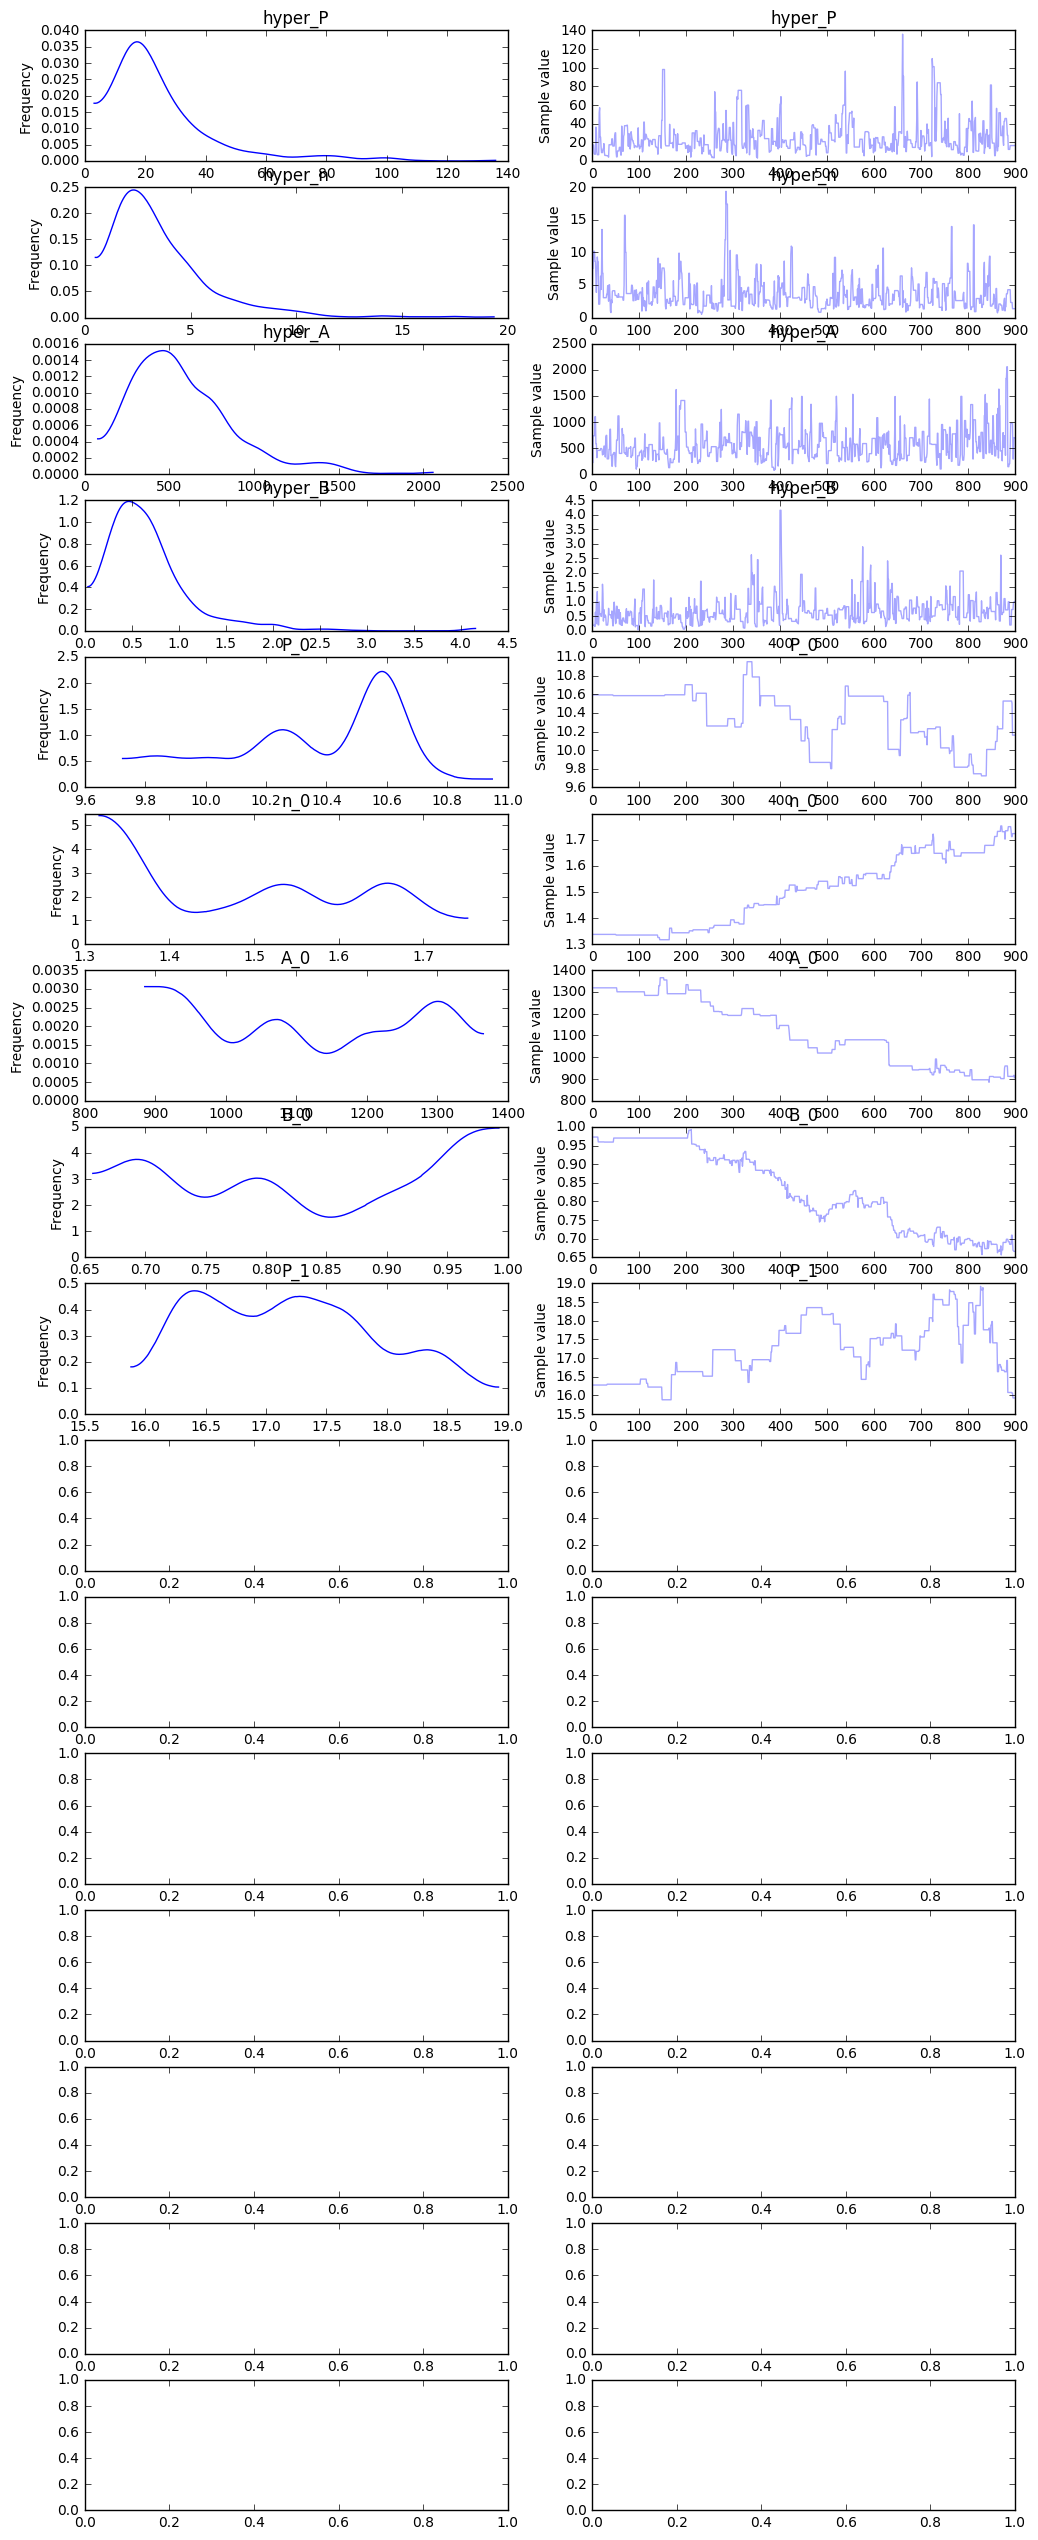

In [13]:
%matplotlib inline
trace = fit_and_plot(sideband_data, samples=1000, burn_period=100, box='MultiJet')
pickle.dump(trace, open('trace_hierarchical_{}.p'.format('MultiJet'), 'wb'))

In [14]:
get_nsigmas(trace, sideband_data, 'MultiJet', 0)

Number of b-tags: 0
1584 1525.0 65.0 0.871333333333 1.13271648332
1635 1727.0 58.0 0.0116666666667 -2.26793229946
675 699.0 39.0 0.196 -0.855995985493
309 317.0 26.0 0.319 -0.470496967905
259 239.0 28.0 0.812 0.88529044883
1006 934.0 41.0 0.993666666667 2.49300610967
984 1011.0 48.0 0.22 -0.772193214189
390 387.0 32.0 0.555666666667 0.139991550126
199 165.0 20.0 0.984666666667 2.16137133336
131 114.0 16.25 0.925666666667 1.44425710616
708 720.0 37.0 0.321333333333 -0.46397359093
504 520.0 34.0 0.255 -0.658837692736
297 321.0 29.0 0.123333333333 -1.15848378101
78 76.0 14.0 0.611 0.281926329587
15 14.0 6.0 0.663 0.420664619638
2 0.0 1.0 0.984666666667 2.16137133336


{0: {(500, 575, 0.25, 0.3): 1.1327164833223333,
  (500, 575, 0.3, 0.41): -2.2679322994583586,
  (500, 575, 0.41, 0.52): -0.85599598549268185,
  (500, 575, 0.52, 0.64): -0.47049696790494139,
  (500, 575, 0.64, 1.5): 0.88529044882964181,
  (575, 650, 0.25, 0.3): 2.4930061096702527,
  (575, 650, 0.3, 0.41): -0.77219321418868481,
  (575, 650, 0.41, 0.52): 0.13999155012642575,
  (575, 650, 0.52, 0.64): 2.1613713333637046,
  (575, 650, 0.64, 1.5): 1.4442571061618694,
  (650, 750, 0.25, 0.3): -0.46397359093012908,
  (750, 900, 0.25, 0.3): -0.65883769273618775,
  (900, 1200, 0.25, 0.3): -1.1584837810112794,
  (1200, 1600, 0.25, 0.3): 0.28192632958706143,
  (1600, 2500, 0.25, 0.3): 0.4206646196376157,
  (2500, 4000, 0.25, 0.3): 2.1613713333637046}}

In [15]:
get_nsigmas(trace, sideband_data, 'MultiJet', 1)

Number of b-tags: 1
724 730.0 47.0 0.43 -0.176374164781
779 769.0 38.0 0.657666666667 0.406103346926
286 281.0 25.0 0.619 0.302855480891
123 114.0 16.0 0.778333333333 0.766576531422
58 74.0 14.0 0.0473333333333 -1.67127857307
427 425.0 29.0 0.554 0.135773931302
403 437.0 30.0 0.063 -1.53006758814
158 154.0 18.25 0.614333333333 0.290631281188
63 61.0 11.0 0.596333333333 0.243867638492
51 37.0 9.0 0.974333333333 1.94868266407
323 311.0 27.0 0.735333333333 0.629024016387
218 208.5 21.0 0.732333333333 0.619885256092
103 115.0 17.0 0.162 -0.986271298702
26 22.0 7.0 0.759333333333 0.704159686542
3 3.0 3.0 0.5 0.0
0 0.0 0.0 0.5 0.0


{1: {(500, 575, 0.25, 0.3): -0.17637416478086135,
  (500, 575, 0.3, 0.41): 0.40610334692586048,
  (500, 575, 0.41, 0.52): 0.30285548089134906,
  (500, 575, 0.52, 0.64): 0.76657653142207649,
  (500, 575, 0.64, 1.5): -1.6712785730694109,
  (575, 650, 0.25, 0.3): 0.13577393130211166,
  (575, 650, 0.3, 0.41): -1.5300675881378287,
  (575, 650, 0.41, 0.52): 0.2906312811882103,
  (575, 650, 0.52, 0.64): 0.24386763849192336,
  (575, 650, 0.64, 1.5): 1.948682664066375,
  (650, 750, 0.25, 0.3): 0.629024016386869,
  (750, 900, 0.25, 0.3): 0.61988525609182688,
  (900, 1200, 0.25, 0.3): -0.98627129870223795,
  (1200, 1600, 0.25, 0.3): 0.70415968654249161,
  (1600, 2500, 0.25, 0.3): 0.0,
  (2500, 4000, 0.25, 0.3): 0.0}}

In [16]:
get_nsigmas(trace, sideband_data, 'MultiJet', 2)

Number of b-tags: 2
272 265.0 24.25 0.671 0.442676144204
260 272.0 23.0 0.224333333333 -0.757639767049
108 98.0 14.0 0.836333333333 0.979499301991
28 39.0 9.0 0.0323333333333 -1.84755553875
29 24.0 7.0 0.798333333333 0.835682872238
159 147.0 17.0 0.842333333333 1.00409394576
138 146.0 17.0 0.258666666667 -0.647461454758
45 49.0 11.0 0.262666666667 -0.63514579278
27 19.0 6.0 0.967 1.83842366925
11 11.0 5.0 0.5 0.0
105 103.0 14.0 0.617 0.297611102233
64 65.0 12.0 0.434 -0.16619944017
27 33.0 9.0 0.163 -0.982202695333
3 6.0 4.0 0.0796666666667 -1.40731726058
4 1.0 1.0 0.997666666667 2.82918532685
0 0.0 0.0 0.5 0.0


{2: {(500, 575, 0.25, 0.3): 0.44267614420382145,
  (500, 575, 0.3, 0.41): -0.75763976704884395,
  (500, 575, 0.41, 0.52): 0.97949930199094148,
  (500, 575, 0.52, 0.64): -1.8475555387467524,
  (500, 575, 0.64, 1.5): 0.83568287223789262,
  (575, 650, 0.25, 0.3): 1.0040939457580305,
  (575, 650, 0.3, 0.41): -0.64746145475775108,
  (575, 650, 0.41, 0.52): -0.63514579277986927,
  (575, 650, 0.52, 0.64): 1.8384236692477769,
  (575, 650, 0.64, 1.5): 0.0,
  (650, 750, 0.25, 0.3): 0.29761110223347992,
  (750, 900, 0.25, 0.3): -0.16619944017035887,
  (900, 1200, 0.25, 0.3): -0.98220269533346993,
  (1200, 1600, 0.25, 0.3): -1.4073172605848239,
  (1600, 2500, 0.25, 0.3): 2.829185326853529,
  (2500, 4000, 0.25, 0.3): 0.0}}

In [10]:
trace = pickle.load(open('trace_hierarchical_{}.p'.format('MultiJet'),'rb'))